In [1]:
# Importamos las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelos de Clasificación
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

# Métricas y funciones útiles
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Para que no aparezcan advertencias no deseadas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importamos los datos
Data = pd.read_csv('data/winequality-red.csv', sep=';')

In [3]:
# Separamos covariables de vector de etiquetas
X = Data.drop(columns='quality')
y = Data['quality']

# Guardamos los valores únicos de y para después
classes = np.unique(y)

## Métodos de Clasificación

### Regresión Logística Multinomial

In [4]:
# Inicializamos y ajustamos el modelo
logreg = LogisticRegression(max_iter=10000, multi_class='multinomial')
logreg.fit(X, y)
# Calculamos y guardamos el score
score_lr = logreg.score(X, y)
print(f'Accuracy de la Regresión Logística: \n {score_lr:.4f}')

Accuracy de la Regresión Logística: 
 0.6010


### One vs Rest

In [5]:
# Inicializamos y ajustamos el modelo
logreg_ovr = LogisticRegression(max_iter=10000, multi_class='ovr')
logreg_ovr.fit(X, y)
# Calculamos y guardamos el score
score_ovr = logreg_ovr.score(X, y)
print(f'Accuracy de la Regresión Logística (One vs Rest): \n {score_lr:.4f}')

Accuracy de la Regresión Logística (One vs Rest): 
 0.6010


### LDA

In [6]:
# Inicializamos y ajustamos el modelo
lda = LDA()
lda.fit(X, y)
# Calculamos y guardamos el score
score_lda = lda.score(X, y)
print(f'Accuracy de LDA: \n {score_lda:.4f}')

Accuracy de LDA: 
 0.6035


### QDA

In [7]:
# Inicializamos y ajustamos el modelo
qda = QDA()
qda.fit(X, y)
# Calculamos y guardamos el score
score_qda = qda.score(X, y)
print(f'Accuracy de QDA: \n {score_qda:.4f}')

Accuracy de QDA: 
 0.6060


### K Vecinos Más Cercanos

In [8]:
# Inicializamos y ajustamos el modelo
knn = KNN()
knn.fit(X, y)
# Calculamos y guardamos el score
score_knn = knn.score(X, y)
print(f'Accuracy de KNN: \n {score_knn:.4f}')

Accuracy de KNN: 
 0.6704


### Gaussian Naive Bayes

In [9]:
# Inicializamos y ajustamos el modelo
gnb = GNB()
gnb.fit(X, y)
# Calculamos y guardamos el score
score_gnb = gnb.score(X, y)
print(f'Accuracy de Bayes Ingenuo: \n {score_gnb:.4f}')

Accuracy de Bayes Ingenuo: 
 0.5647


### Matrices de Confusión

In [ ]:
# Guardamos cada modelo en un diccionario
modelos = {'Reg Log': logreg, 'Reg Log OvR': logreg_ovr, 'Bayes': gnb, 'LDA': lda, 'QDA': qda, 'KNN': knn}

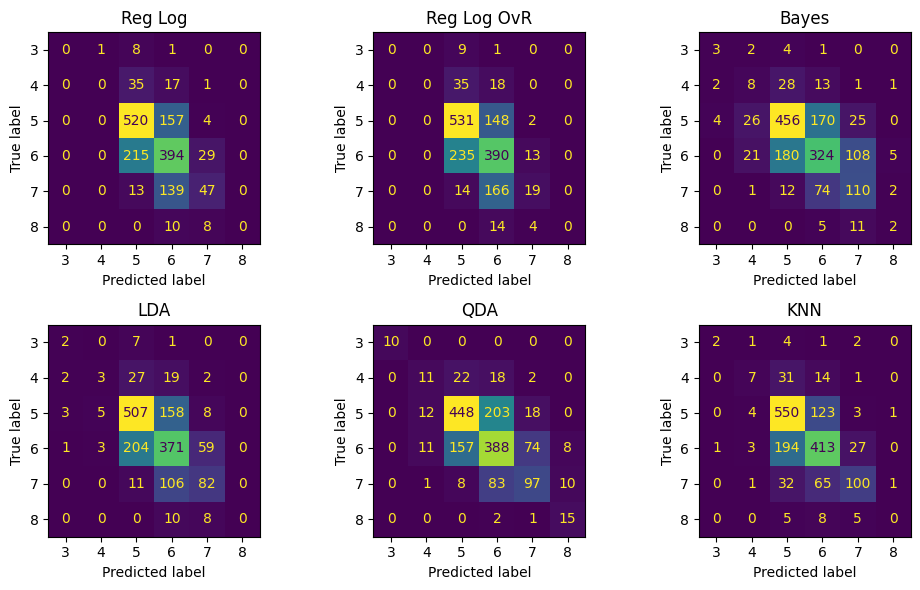

In [11]:
# Inicializamos la grilla
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Aplanamos el array para poder iterar
axes = axes.flatten()

# Iteramos sobre axes y cada modelo
for ax, (nombre, modelo) in zip(axes, modelos.items()):
    # Ajustamos y predecimos usando todo el dataset
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(nombre)
plt.tight_layout()
plt.show()

### CV sobre el hiperparámetro k del modelo KNN
Tomando como punto de partida a X con únicamente las variables estadísticamente significativas y escalando los datos en el proceso

In [12]:
X_es = X[["volatile acidity", "chlorides","free sulfur dioxide", 
           "total sulfur dioxide", "pH", "sulphates", "alcohol"]]

X_train, X_test, y_train, y_test = train_test_split(X_es, y, test_size= 0.2, random_state= 42)

In [ ]:
# Grilla de parámetros a evaluar
parametros_grid = {
       "knn__n_neighbors": list(range(1, 31)),
        "knn__metric": ["euclidean", "manhattan"]
        }

from sklearn.pipeline import Pipeline
# Implementación mediante pipelines
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNN())
])

In [14]:
best_knn = GridSearchCV(pipe, parametros_grid, cv = 5, scoring= "accuracy")
best_knn.fit(X_train,y_train)
y_pred = best_knn.predict(X_test)
print("Accuracy obtenido: ", accuracy_score(y_test, y_pred))
print("**********")
print(classification_report(y_test, y_pred))

Accuracy obtenido:  0.59375
**********
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.65      0.78      0.71       130
           6       0.56      0.57      0.57       132
           7       0.43      0.31      0.36        42
           8       0.00      0.00      0.00         5

    accuracy                           0.59       320
   macro avg       0.27      0.28      0.27       320
weighted avg       0.55      0.59      0.57       320



In [ ]:
best_knn.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 20}

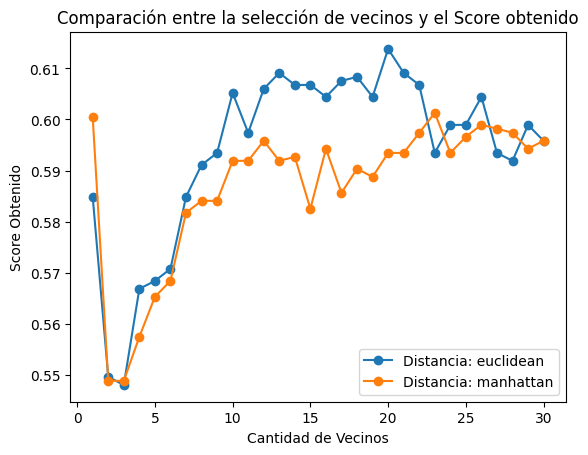

In [16]:
# Guardamos los resultados en un DF
resultados = pd.DataFrame(best_knn.cv_results_)
# Nos quedamos solo con los parámetros y el score
resultados_filtrados = resultados[["param_knn__n_neighbors", "param_knn__metric", "mean_test_score"]]

for metrica in resultados_filtrados["param_knn__metric"].unique():
    data_final = resultados_filtrados[resultados_filtrados["param_knn__metric"] == metrica]
    plt.plot(data_final["param_knn__n_neighbors"], data_final["mean_test_score"], label=f"Distancia: {metrica}", marker='o')
    plt.xlabel("Cantidad de Vecinos")
    plt.ylabel("Score Obtenido")
    plt.legend()
    plt.title("Comparación entre la selección de vecinos y el Score obtenido")

### CV sobre todos los modelos con el Accuracy como métrica: 5-folds Estratificados

In [ ]:
# Definido de esta manera, knn buscará el mejor k mediante validación cruzada en cada ajuste
# Es importante ya que a continuación se ajustará múltiples veces con distintas transformaciones del dataset
KNN = KNN()
knn = GridSearchCV(KNN, parametros_grid, cv = 5, scoring= "accuracy")

In [ ]:
# Definimos la función para encontrar el mejor modelo
def CrossValidate(title, modelos, best_scores, X, y):
    # Inicializamos un DataFrame para guardar los scores
    scores = pd.DataFrame(columns=(list(modelos.keys())))
    # Inicializamos el K-Fold Estratificado
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Iteramos sobre cada fold
    for i, (train, test) in enumerate(kf.split(X, y)):
        # Iteramos sobre cada modelo
        for model in scores.columns:
            # Entrenamos el modelo y guardamos el score
            modelos[model].fit(X.iloc[train], y.iloc[train])
            scores.loc[i, model] = modelos[model].score(X.iloc[test], y.iloc[test])

    # Calculamos y guardamos el Accuracy promedio para cada modelo
    scores.loc['Promedio'] = np.mean(scores, axis=0)
    print(scores)
    # El modelo con mejor Accuracy medio
    best_acc = scores.loc['Promedio'].max()
    best_model = scores.loc['Promedio'].idxmax()
    best_scores[title] = (best_model, best_acc)
    print(f'Mejor modelo: {best_model}. Accuracy = {best_acc:.5f}')

In [19]:
X = Data.drop(columns=['quality'])
y = Data['quality']

# Inicializamos otro diccionario para guardar los mejores scores
best_scores = {}

CrossValidate('Todas las Covariables', modelos, best_scores, X, y)

           Reg Log Reg Log OvR     Bayes       LDA       QDA       KNN
0              0.6    0.596875     0.575    0.6125   0.58125    0.5375
1          0.58125    0.546875   0.54375  0.590625  0.590625  0.490625
2           0.6125     0.61875  0.528125  0.590625    0.5875   0.51875
3         0.603125    0.578125   0.56875   0.60625    0.5125     0.475
4         0.598746    0.586207  0.579937  0.592476  0.567398  0.482759
Promedio  0.599124    0.585366  0.559112  0.598495  0.567855  0.500927
Mejor modelo: Reg Log. Accuracy = 0.59912


### Ahora usando sólo las covariables estadísticamente significativas

In [20]:
CrossValidate('Est. Significativas', modelos, best_scores, X_es, y)

           Reg Log Reg Log OvR     Bayes       LDA       QDA       KNN
0         0.615625    0.584375  0.584375  0.596875  0.553125  0.565625
1         0.565625        0.55  0.590625   0.59375  0.571875   0.51875
2         0.603125     0.60625   0.58125   0.60625   0.56875  0.553125
3         0.584375     0.56875  0.571875  0.596875  0.534375  0.540625
4          0.60815    0.592476  0.595611  0.598746  0.589342   0.53605
Promedio   0.59538     0.58037  0.584747  0.598499  0.563493  0.542835
Mejor modelo: LDA. Accuracy = 0.59850


### Ahora estandarizando las variables explicativas estadísticamente significativas

In [ ]:
scaler = StandardScaler()
X_s = pd.DataFrame(scaler.fit_transform(X_es))

In [22]:
CrossValidate('E. S. Estandarizadas', modelos, best_scores, X_s, y)

           Reg Log Reg Log OvR     Bayes       LDA       QDA       KNN
0              0.6      0.5875  0.584375  0.596875  0.553125  0.534375
1          0.59375    0.553125  0.590625   0.59375  0.571875  0.565625
2         0.609375     0.60625   0.58125   0.60625   0.56875   0.55625
3         0.615625       0.575  0.571875  0.596875  0.534375  0.640625
4         0.605016    0.589342  0.595611  0.598746  0.589342  0.579937
Promedio  0.604753    0.582243  0.584747  0.598499  0.563493  0.575362
Mejor modelo: Reg Log. Accuracy = 0.60475


### Ahora estandarizando todas las variables explicativas

In [ ]:
X = Data.drop(columns=['quality'])
X = pd.DataFrame(scaler.fit_transform(X))

In [24]:
CrossValidate('Todas Estandarizadas', modelos, best_scores, X, y)

           Reg Log Reg Log OvR     Bayes       LDA       QDA       KNN
0              0.6     0.59375  0.571875    0.6125   0.58125    0.5375
1          0.58125    0.565625  0.540625  0.590625  0.590625  0.565625
2         0.615625    0.615625  0.515625  0.590625    0.5875  0.565625
3           0.6125     0.58125   0.55625   0.60625    0.5125  0.590625
4         0.586207    0.579937  0.561129  0.592476  0.567398  0.548589
Promedio  0.599116    0.587237  0.549101  0.598495  0.567855  0.561593
Mejor modelo: Reg Log. Accuracy = 0.59912


### Mejores Métricas

In [25]:
for key, val in best_scores.items():
    print(f'Para {key:<22}: mejor modelo: {val[0]:<8}, accuracy = {val[1]:.5f}')

Para Todas las Covariables : mejor modelo: Reg Log , accuracy = 0.59912
Para Est. Significativas   : mejor modelo: LDA     , accuracy = 0.59850
Para E. S. Estandarizadas  : mejor modelo: Reg Log , accuracy = 0.60475
Para Todas Estandarizadas  : mejor modelo: Reg Log , accuracy = 0.59912
